In [1]:
import logging
import os
import random
import sys
from collections import deque

sys.path.insert(0, './')

In [2]:
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import tensorflow.contrib.slim as slim
from nets.mobilenet import mobilenet_v2

BATCH_SIZE = 32
IMAGE_SIZE = 224

iter = 100000
lr = 0.001

checkpoint_name = './mobilenet_v2_1.0_224/mobilenet_v2_1.0_224.ckpt'
ckpt_dir = './checkpoints'

tf.__version__

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



'1.15.0'

In [3]:
def set_random_seed():
    seed = random.randrange(2 ** 32 - 2)
    logging.info('Using random seed {}'.format(seed))
    random.seed(seed)
    np.random.seed(seed + 1)
    tf.set_random_seed(seed + 2)
    
set_random_seed()

In [4]:
from dataset_factory import ImageCollector, ImgInverNormalize
import matplotlib.pyplot as plt
from matplotlib import cm

In [5]:
dataset = ImageCollector("./ARVision Data", 1, 100, 32) # Real data
dataset.StartLoadData()

module name: dataset_factory
parent process: 6811
process id: 21446


In [6]:
train_data = dataset.getLoadedData()

max : 0.6862745098039216
min : -1.0


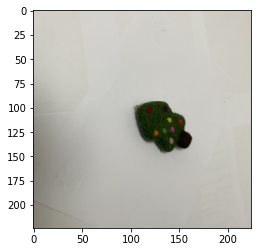

In [7]:
print("max : " + str(train_data[1][0].max()))
print("min : " + str(train_data[1][0].min()))

plt.imshow(ImgInverNormalize(train_data[1][0], 1.))
# plt.imshow(train_data[1][0])
plt.show()

In [8]:
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

input_img = tf.placeholder(tf.float32, [None] + [IMAGE_SIZE, IMAGE_SIZE, 3])
input_label = tf.placeholder(tf.float32, [None] + [6])

In [9]:
with tf.contrib.slim.arg_scope(mobilenet_v2.training_scope(is_training=False)):
    logits, endpoints = mobilenet_v2.mobilenet(input_img, num_classes=6)
    
cost = tf.reduce_mean(tf.square(endpoints['6DOF'] - input_label))
train_op = tf.train.AdamOptimizer(lr, beta1=0.5).minimize(cost)

Instructions for updating:
Please use `layer.__call__` method instead.


Instructions for updating:
Please use `layer.__call__` method instead.


In [10]:
sess = tf.Session()

sess.run(tf.global_variables_initializer())
reuse_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="MobilenetV2")
reuse_var_refine = [var for var in reuse_vars if '6DOF' not in var.name]

saver = tf.train.Saver(var_list=reuse_var_refine)
new_saver = tf.train.Saver()

saver.restore(sess, checkpoint_name)

INFO:tensorflow:Restoring parameters from ./mobilenet_v2_1.0_224/mobilenet_v2_1.0_224.ckpt


INFO:tensorflow:Restoring parameters from ./mobilenet_v2_1.0_224/mobilenet_v2_1.0_224.ckpt


In [ ]:
from time import sleep

t = tqdm(range(iter))
loss_print = ""

for i in t:
    train_data = dataset.getLoadedData()
    t.set_description(loss_print)
    _, loss_val = sess.run([train_op, cost], feed_dict={input_img: train_data[1], input_label: train_data[2]})

    if i % 100:
        loss_print = 'Step: [' + str(i) + '/' + str(iter) + '], loss: ' + str(loss_val)

    if i % 5000 == 0:
        saver.save(sess, ckpt_dir + '/model_iter' + str(i))

Step: [34/100000], loss: 1.261795:   0%|          | 35/100000 [02:49<152:31:30,  5.49s/it]  

In [ ]:
with sess.as_default():
    train_data = dataset.getLoadedData()
    x = endpoints['6DOF'].eval(feed_dict={input_img: train_data[1]})

In [ ]:
x[0]

# Save Trained Model

In [ ]:
save_dir = './checkpoints'
save_path = os.path.join(save_dir, 'model.ckpt')
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
save_path = new_saver.save(sess, save_path)
tf.train.write_graph(sess.graph, './', 'model.pbtxt')

# Tensorflow to CoreML

In [ ]:
from tensorflow.python.tools.freeze_graph import freeze_graph
import tfcoreml
import coremltools
from PIL import Image

In [ ]:
# Provide these to run freeze_graph:
# Graph definition file, stored as protobuf TEXT
graph_def_file = './model.pbtxt'
# Trained model's checkpoint name
checkpoint_file = './checkpoints/model.ckpt'
# Frozen model's output name
frozen_model_file = './frozen_model.pb'
# Output nodes. If there're multiple output ops, use comma separated string, e.g. "out1,out2".
output_node_names = 'MobilenetV2/Logits/6DOF' 


# Call freeze graph
freeaed = freeze_graph(input_graph=graph_def_file,
                       input_saver="",
                       input_binary=False,
                       input_checkpoint=checkpoint_file,
                       output_node_names=output_node_names,
                       restore_op_name="save/restore_all",
                       filename_tensor_name="save/Const:0",
                       output_graph=frozen_model_file,
                       clear_devices=True,
                       initializer_nodes="")

In [ ]:
"""
Step 2: Call converter
"""

# Provide these inputs in addition to inputs in Step 1
# A dictionary of input tensors' name and shape (with batch)
IMAGE_INPUT_NAME = ["Placeholder"]
input_tensor_shapes = {"Placeholder":[1,224,224,3]} # batch size is 1
# Output CoreML model path
coreml_model_file = './AR3DVision.mlmodel'
output_tensor_names = ['MobilenetV2/Logits/6DOF']


# Call the converter
# coreml_model = tfcoreml.convert(
#     tf_model_path=frozen_model_file, 
#     mlmodel_path=coreml_model_file, 
#     input_name_shape_dict=input_tensor_shapes,
#     output_feature_names=output_tensor_names,
#     minimum_ios_deployment_target='13')

coreml_model = tfcoreml.convert(
    tf_model_path=frozen_model_file, 
    mlmodel_path=coreml_model_file,
    image_input_names=IMAGE_INPUT_NAME,
    input_name_shape_dict=input_tensor_shapes,
    output_feature_names=output_tensor_names,
    minimum_ios_deployment_target='13',
    image_scale=2.0/255.0,
    red_bias=-1,
    green_bias=-1,
    blue_bias=-1)

In [ ]:
# Test CoreML convert result
formatted = (ImgInverNormalize(train_data[1][0], 255).astype('uint8'))
# coreml_test_data = train_data[1][0][np.newaxis,:]
coreml_test_data = Image.fromarray(formatted)
coreml_inputs = {'Placeholder': coreml_test_data} # (batch=1,W=224, H=224, C=3)
coreml_output = coreml_model.predict(coreml_inputs, useCPUOnly=True)

print("label : ", train_data[2][0])
print(x[0])
print(coreml_output)

# CoreML Preprocess info

In [ ]:
from coremltools.proto import FeatureTypes_pb2 as _FeatureTypes_pb2

spec = coremltools.models.utils.load_spec(coreml_model_file)
print(spec.WhichOneof('Type'))
if spec.WhichOneof('Type') == 'neuralNetworkClassifier':
  nn = spec.neuralNetworkClassifier
if spec.WhichOneof('Type') == 'neuralNetwork':
  nn = spec.neuralNetwork  
if spec.WhichOneof('Type') == 'neuralNetworkRegressor':
  nn = spec.neuralNetworkRegressor

preprocessing = nn.preprocessing[0].scaler
print( 'channel scale: ', preprocessing.channelScale)
print( 'blue bias: ', preprocessing.blueBias)
print( 'green bias: ', preprocessing.greenBias)
print( 'red bias: ', preprocessing.redBias)

inp = spec.description.input[0]
if inp.type.WhichOneof('Type') == 'imageType':
  colorspace = _FeatureTypes_pb2.ImageFeatureType.ColorSpace.Name(inp.type.imageType.colorSpace)
  print( 'colorspace: ', colorspace)

2.0 / 255.0